In [1]:
%pylab inline

import os
import argparse
import itertools
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

import models

parser = argparse.ArgumentParser()
parser.add_argument('--embeddings', default = './embeddings')
parser.add_argument('--transcripts', default = './dia_dataset/diacalls_short_2020-09-01_2020-10-01.ref')
parser.add_argument('--vis', default = './vis')
args, _ = parser.parse_known_args()

os.makedirs(args.vis, exist_ok = True)

i, audio_name_pt = (0, '_ES2004a.Mix-Headset.wav.pt')

input_path = os.path.join(args.embeddings, audio_name_pt)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#speaker_id = models.convert_speaker_id(torch.load(os.path.join(args.transcripts, os.path.basename(audio_name_pt).replace('.wav.pt', '.pt')), 'cpu'), to_bipole = True)
#speaker_id = F.interpolate(speaker_id.view(1, 1, -1).to(torch.float32), len(emb)).flatten().to(torch.int8)

In [ ]:
def normalized_symmetric_laplacian(W):
	# https://en.wikipedia.org/wiki/Laplacian_matrix#Symmetric_normalized_Laplacian
	D_sqrt = W.sum(dim = -1).sqrt()
	return torch.eye(W.shape[-1], device = W.device, dtype = W.dtype) - W / D_sqrt.unsqueeze(-1) / D_sqrt.unsqueeze(-2)

def cosine_kernel(E):
	E = F.normalize(E, dim = 1)
	return E @ E.t()

def wang_affinity(E, gaussian_kernel_size = 9, gaussian_sigma = 1.0, row_threshold = 0.95, shrinking = 0.01):
	# Speaker Diarization with LSTM, Wang et al, https://arxiv.org/abs/1710.10468
	# https://github.com/wq2012/SpectralCluster/blob/master/spectralcluster/spectral_clusterer.py
	A = cosine_kernel(E)

	# crop diagonalw
	A.fill_diagonal_(0)
	A.diagonal().copy_(A.max(dim = 1).values)

	## gaussian blur
	#A = F.conv2d(A[None, None, ...], gaussian_kernel([gaussian_kernel_size] * 2, [gaussian_sigma] * 2).type_as(A))[0, 0, ...]

	# row-wise shrinking
	A = torch.where(A > row_threshold * A.max(dim = 1, keepdim = True).values, A, shrinking * A)

	# symmetrization
	A = torch.max(A, A.t())

	# diffusion
	A = A @ A

	# row-wise normalization
	A = A / A.max(dim = 1, keepdim = True).values
	A = torch.max(A, A.t())

	return A


K tensor(-0.0417) tensor(1.0000)
W 0.0 1.0
tensor(-0.9398) tensor(1.)
tensor([[1.8066, 1.9883, 2.1951,  ..., 0.9606, 0.9962, 0.9969],
        [1.9883, 1.7792, 2.0385,  ..., 0.9471, 0.9618, 0.9970],
        [2.1951, 2.0385, 1.9116,  ..., 0.9474, 0.9540, 0.9680],
        ...,
        [0.9606, 0.9471, 0.9474,  ..., 1.9398, 2.0304, 2.1705],
        [0.9962, 0.9618, 0.9540,  ..., 2.0304, 1.9398, 2.0514],
        [0.9969, 0.9970, 0.9680,  ..., 2.1705, 2.0514, 1.8525]])
eigvals tensor([-9.0747e-08,  2.1829e-01,  3.1681e-01,  6.6453e-01,  8.3584e-01,
         9.0957e-01,  9.1728e-01,  9.2363e-01,  9.3884e-01,  9.4876e-01,
         9.5290e-01,  9.5353e-01,  9.5904e-01,  9.6747e-01,  9.7151e-01,
         9.7380e-01,  9.7989e-01,  9.8103e-01,  9.9082e-01,  9.9538e-01,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.00

Text(0.5, 0.98, '_ES2004a.Mix-Headset.wav.pt')

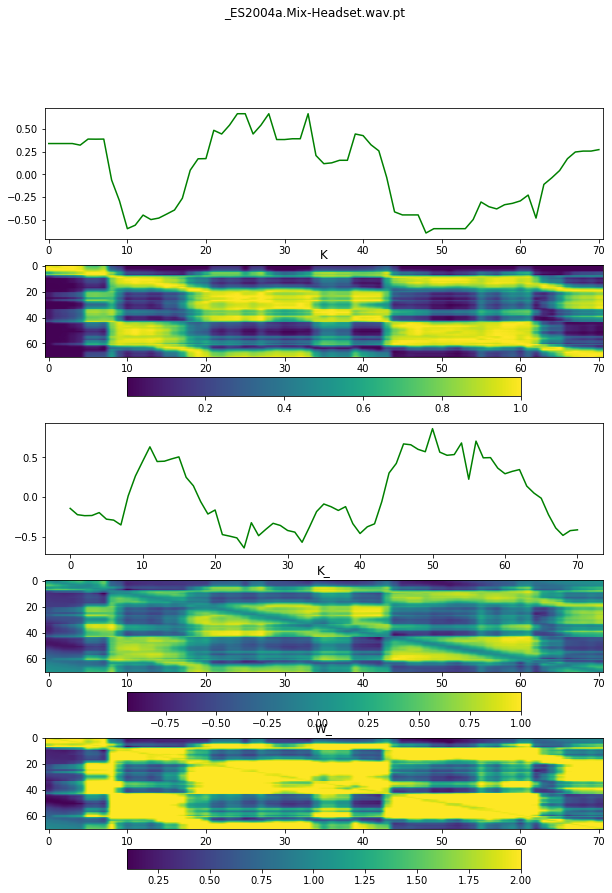

In [3]:
#K = models.wang_affinity(emb, row_threshold = 0.50)
#K = (1 + K) / 2

emb = torch.load(input_path, map_location = 'cpu').t()
norms = emb.norm(p = 2, dim = 1)
#print('norms', norms)

K = models.cosine_kernel(emb)

print('K', K.min(), K.max())
K = K / K.abs().max()
ACF, M = models.acf(K)

K = models.wang_affinity(emb, row_threshold = 0.5)

#dist = 1 - K
#T = 5
#W = torch.exp(-1/T * dist)
#dist = pdist(emb, squared = True)
#dist = 100 * dist
#print('dist', dist.min(), dist.max())


#W = torch.where(K > 0.5, K.clamp(max = 0.6), torch.zeros_like(K))
W = (K > 0.5).float()

#print('dist mean', dist.mean(), 'W mean', W.mean())
W_min, W_max = float(W.min()), float(W.max())
print('W', W_min, W_max)

K_ = (K - M) / (K - M).abs().max()
print(K_.min(), K_.max())
W_ = K + K_ - K_.min()
print(W_)
#W_ = (K_ > 0.5).float()

L = models.normalized_symmetric_laplacian(W)
eigvals, eigvecs = L.symeig(eigenvectors = True)
eigvecs = eigvecs[:, 1 : 10]
eigvecs = F.normalize(eigvecs, p = 2, dim = -1)
print('eigvals', eigvals)

L_ = models.normalized_symmetric_laplacian(W_)
eigvals_, eigvecs_ = L_.symeig(eigenvectors = True)
eigvecs_ = eigvecs_[:, 1 : 10]
eigvecs_ = F.normalize(eigvecs_, p = 2, dim = -1)

eigvecs_max = 1

#assignment, eigvecs = models.spectral_clustering(L, e = 3, k = 3)
#speaker_id_ = models.convert_speaker_id(models.reassign_speaker_id(assignment, models.convert_speaker_id(speaker_id, from_bipole = True)), to_bipole = True)

plt.figure(figsize = (10, 14))
ax = plt.subplot(511)
#plt.plot(speaker_id, color = 'r')
#plt.plot(speaker_id_ + 0.01, color = 'b')
plt.plot(eigvecs[:, 0] / eigvecs_max, color = 'g')
plt.subplot(512, sharex = ax)
plt.imshow(K, aspect = 'auto')
plt.colorbar(orientation = 'horizontal')
plt.title('K')

plt.subplot(513)
print('eigvecs_max', eigvecs_max)
plt.plot(eigvecs_[:, 0] / eigvecs_max, color = 'g')
plt.subplot(514, sharex = ax)
plt.imshow(K_, aspect = 'auto')
plt.colorbar(orientation = 'horizontal')
plt.title('K_')

plt.subplot(515, sharex = ax)
plt.imshow(W_.clamp(max = 2.0), aspect = 'auto')
plt.colorbar(orientation = 'horizontal')
plt.title('W_')


#plt.subplot(313)
#plt.hist(K.flatten().numpy(), bins = 50)
#plt.title('K')

plt.suptitle(audio_name_pt)
#plt.savefig(os.path.join(args.vis, audio_name_pt + '.png'))
#plt.close()